# Large-scale proteogenomics to refine wheat genome annotations
__Author:__ Delphine Vincent

I created this notebook to clean, parse and analyse the data for my scientific paper "Community resource: Large-scale proteogenomics to refine wheat genome annotations" published in IJMS in 2024.   
Feel free to download it and use it for your needs but please cite/acknowledge me if you do so.

## 1/ Loading gene and mapped peptide data
The peptides (from Duncan et al 2017 study) for which I've obtained tBLASTn hits are not assigned IWGSC 2.1 gene names, therefore I'm using Python to retrieve those gene names.   
files needed:    
- 1: gene names and chromosomal positions = iwgsc_refseqv2.1_annotation_200916_HC-LC_gff3_genes.txt (this was retrieved from https://urgi.versailles.inrae.fr/download/iwgsc/IWGSC_RefSeq_Annotations/v2.1/)  
- 2: peptide genomic positions = Vincent_suppl-tableS2.txt (this corresponds to the first 27 columns of Suppl. Table S1 of the supplmentary data).  

In [14]:
# load library
import pandas as pd

# Load tBLASTn Peptides
tblastn_file = "Vincent_suppl-tableS2.txt" # NOTE: txt file was created from excel
tblastn_df = pd.read_csv(tblastn_file, sep="\t")
print('tblastn_df dataframe:')
print("Dimensions of tblastn_df DataFrame: ", tblastn_df.shape) # (92719, 27)
print("Columns of tblastn_df DataFrame: ", tblastn_df.columns)
print(tblastn_df.head(3))

# Load wheat genes
gene_file = "iwgsc_refseqv2.1_annotation_200916_HC-LC_gff3_genes.txt" # NOTE: unnecessary columns were removed in Excel prior to python load
gene_df = pd.read_csv(gene_file, sep="\t")
print('gene_df dataframe:')
print("Dimensions of gene_df DataFrame: ", gene_df.shape) # (266760, 17) only positive strand
print("Columns of gene_df DataFrame: ", gene_df.columns)
print(gene_df.head(3))


tblastn_df dataframe:
Dimensions of tblastn_df DataFrame:  (92719, 27)
Columns of tblastn_df DataFrame:  Index(['index', 'Source', 'tissue', 'tissue_nb', 'protein', 'qseq', 'chr_nb',
       'saccver', 'sstart', 'send', 'qseq.1', 'score', 'strand', 'strand_nb',
       'qaccver', 'pident', 'length', 'mismatch', 'gapopen', 'evalue',
       'bitscore', 'nident', 'positive', 'gaps', 'ppos', 'qframe', 'sframe'],
      dtype='object')
   index                   Source           tissue  tissue_nb                protein                     qseq  chr_nb saccver   sstart     send                   qseq.1  score strand  strand_nb                           qaccver  pident  length  mismatch  gapopen        evalue  bitscore  nident  positive  gaps   ppos  qframe  sframe
0      8  Vincent et al 2022 2023  01_STORED_GRAIN          2  TraesCS1A03G0004900.1        IIKRVEELVKTIKDQYL       1   Chr1A  1208087  1208137        LYQDKITKVLEEVRKII     79      -          0  TraesCS1A03G0004900.1_pep_000002   100.

## 2/ Gene name retrieval

Below is the code to find gene names using start and end genomic positions of mapped peptides. 

Columns of tblastn_df DataFrame:  ['index', 'Source', 'tissue', 'tissue_nb', 'protein', 'qseq', 'chr_nb','saccver', 'sstart', 'send', 'qseq.1', 'score', 'strand', 'strand_nb','qaccver', 'pident', 'length', 'mismatch', 'gapopen', 'evalue','bitscore', 'nident', 'positive', 'gaps', 'ppos', 'qframe', 'sframe']

Columns of gene_df DataFrame:  ['seqid_IGB', 'seqid_Apollo', 'source', 'type', 'start', 'end', 'gene','score', 'strand', 'phase', 'attributes_ID', 'attributes_parent','HC-LC', 'gene.1', 'start.1', 'end.1', 'end>start']    


In [17]:
# NOTE: this step takes a lot of time.
# Initialize an empty list to store the gene names
gene_names = []

# Loop through each row in tblastn_df
for index, row in tblastn_df.iterrows():
    # Check conditions
    condition = (gene_df['seqid_Apollo'] == row['saccver']) & \
                (gene_df['start'] <= row['sstart']) & \
                (gene_df['end'] >= row['send'])
    
    # Retrieve gene name if conditions are met
    matching_genes = gene_df[condition]['gene'].tolist()
    
    # Append the gene name to the list
    if matching_genes:
        gene_names.append(matching_genes[0])  # keeping only one matching gene, adjust if needed
    else:
        gene_names.append(None)  # If no matching gene is found, append None

# Add the gene names list as a new column to tblastn_df
tblastn_df['gene'] = gene_names

# print('tblastn_df dataframe:')
print("Dimensions of tblastn_df DataFrame: ", tblastn_df.shape) # (92719, 25)
print("Columns of tblastn_df DataFrame: ", tblastn_df.columns)
print(tblastn_df.head(3))

Dimensions of tblastn_df DataFrame:  (92719, 28)
Columns of tblastn_df DataFrame:  Index(['index', 'Source', 'tissue', 'tissue_nb', 'protein', 'qseq', 'chr_nb',
       'saccver', 'sstart', 'send', 'qseq.1', 'score', 'strand', 'strand_nb',
       'qaccver', 'pident', 'length', 'mismatch', 'gapopen', 'evalue',
       'bitscore', 'nident', 'positive', 'gaps', 'ppos', 'qframe', 'sframe',
       'gene'],
      dtype='object')
   index                   Source           tissue  tissue_nb                protein                     qseq  chr_nb saccver   sstart     send                   qseq.1  score strand  strand_nb                           qaccver  pident  length  mismatch  gapopen        evalue  bitscore  nident  positive  gaps   ppos  qframe  sframe                 gene
0      8  Vincent et al 2022 2023  01_STORED_GRAIN          2  TraesCS1A03G0004900.1        IIKRVEELVKTIKDQYL       1   Chr1A  1208087  1208137        LYQDKITKVLEEVRKII     79      -          0  TraesCS1A03G0004900.1_pep

In [29]:
# discriminate between peptides from HC or LC genes and as well as novel peptides
# Define a function to apply the logic
def categorize_gene(gene):
    if gene is None or gene == '':
        return 'novel'
    elif 'LC' in gene:
        return 'LC'
    else:
        return 'HC'

# Apply the function to create the new column 'HC_LC'
tblastn_df['HC_LC'] = tblastn_df['gene'].apply(categorize_gene)

# Create new column 'HCLC_nb' that converts HC_LC to numbers for stats
tblastn_df['HCLC_nb'] = tblastn_df['HC_LC'].map({'novel': 1, 'LC': 2, 'HC': 3})

# Display the updated DataFrame
print(tblastn_df[['gene', 'HC_LC','HCLC_nb' ]].head(10))

                    gene HC_LC  HCLC_nb
0    TraesCS1A03G0004900    HC        3
1    TraesCS1A03G0015500    HC        3
2    TraesCS1A03G0019600    HC        3
3    TraesCS1A03G0019600    HC        3
4    TraesCS1A03G0019600    HC        3
5    TraesCS1A03G0019600    HC        3
6  TraesCS1A03G0020300LC    LC        2
7  TraesCS1A03G0020300LC    LC        2
8  TraesCS1A03G0020300LC    LC        2
9  TraesCS1A03G0020300LC    LC        2


In [31]:
# Save the DataFrame as a TXT file
tblastn_df.to_csv('Vincent_suppl-tableS2_with-genes.txt', sep='\t', index=True)

# 3/ Statistics and Visualisation

file needed:
- 2: peptide genomic positions with gene names= Vincent_suppl-tableS2_with-genes.txt

In [33]:
# load libraries 
import pingouin as pg
import csv
import scipy.stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [36]:
# displaying df information
tblastn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92719 entries, 0 to 92718
Data columns (total 30 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   index      92719 non-null  int64  
 1   Source     92719 non-null  object 
 2   tissue     92719 non-null  object 
 3   tissue_nb  92719 non-null  int64  
 4   protein    92719 non-null  object 
 5   qseq       92719 non-null  object 
 6   chr_nb     92719 non-null  int64  
 7   saccver    92719 non-null  object 
 8   sstart     92719 non-null  int64  
 9   send       92719 non-null  int64  
 10  qseq.1     92719 non-null  object 
 11  score      92719 non-null  int64  
 12  strand     92719 non-null  object 
 13  strand_nb  92719 non-null  int64  
 14  qaccver    92719 non-null  object 
 15  pident     92719 non-null  float64
 16  length     92719 non-null  int64  
 17  mismatch   92719 non-null  int64  
 18  gapopen    92719 non-null  int64  
 19  evalue     92719 non-null  float64
 20  bitsco

In [42]:
# displaying summary statistics for numerical variables for the whole df
summary = tblastn_df.describe()
print(summary)
# Save the output as a TXT file without headers
summary.to_csv('Vincent_suppl-tableS2_summary-stats.txt', sep='\t')

# displaying summary statistics for categorical variables for the whole df
print(tblastn_df.describe(include="object"))

              index     tissue_nb        chr_nb        sstart          send         score     strand_nb        pident        length      mismatch       gapopen        evalue      bitscore        nident      positive          gaps          ppos   qframe        sframe       HCLC_nb
count  92719.000000  92719.000000  92719.000000  9.271900e+04  9.271900e+04  92719.000000  92719.000000  92719.000000  92719.000000  92719.000000  92719.000000  9.271900e+04  92719.000000  92719.000000  92719.000000  92719.000000  92719.000000  92719.0  92719.000000  92719.000000
mean   46360.000000     16.264013     10.688769  3.652413e+08  3.652414e+08    121.810697      0.497665     98.779968     22.201383      0.109018      0.018065  6.634964e-04     57.154573     21.656629     21.680141      0.437871     98.889866      0.0     -0.017494      2.864386
std    26765.814142      8.326068      5.819699  2.419233e+08  2.419233e+08     39.380426      0.499997      6.720654      9.455479      0.659347      0.1502

In [44]:
# displaying summary statistics for numerical variables for each tissue
summary_by_tissue = tblastn_df.groupby('tissue').describe().stack()
print(summary_by_tissue)

# Save the output as a TXT file without headers
summary_by_tissue.to_csv('Vincent_suppl-tableS2_summary-stats-by-tissue.txt', sep='\t')

                               index  tissue_nb       chr_nb        sstart          send        score    strand_nb       pident       length     mismatch      gapopen        evalue     bitscore       nident     positive         gaps         ppos  qframe       sframe      HCLC_nb
tissue                                                                                                                                                                                                                                                                                 
01_STORED_GRAIN  count   5302.000000     5302.0  5302.000000  5.302000e+03  5.302000e+03  5302.000000  5302.000000  5302.000000  5302.000000  5302.000000  5302.000000  5.302000e+03  5302.000000  5302.000000  5302.000000  5302.000000  5302.000000  5302.0  5302.000000  5302.000000
                 mean   46595.570351        2.0    10.789891  3.430041e+08  3.430042e+08   104.940211     0.477933    99.168594    18.391928     0.046398     0.

<Figure size 100x100 with 0 Axes>

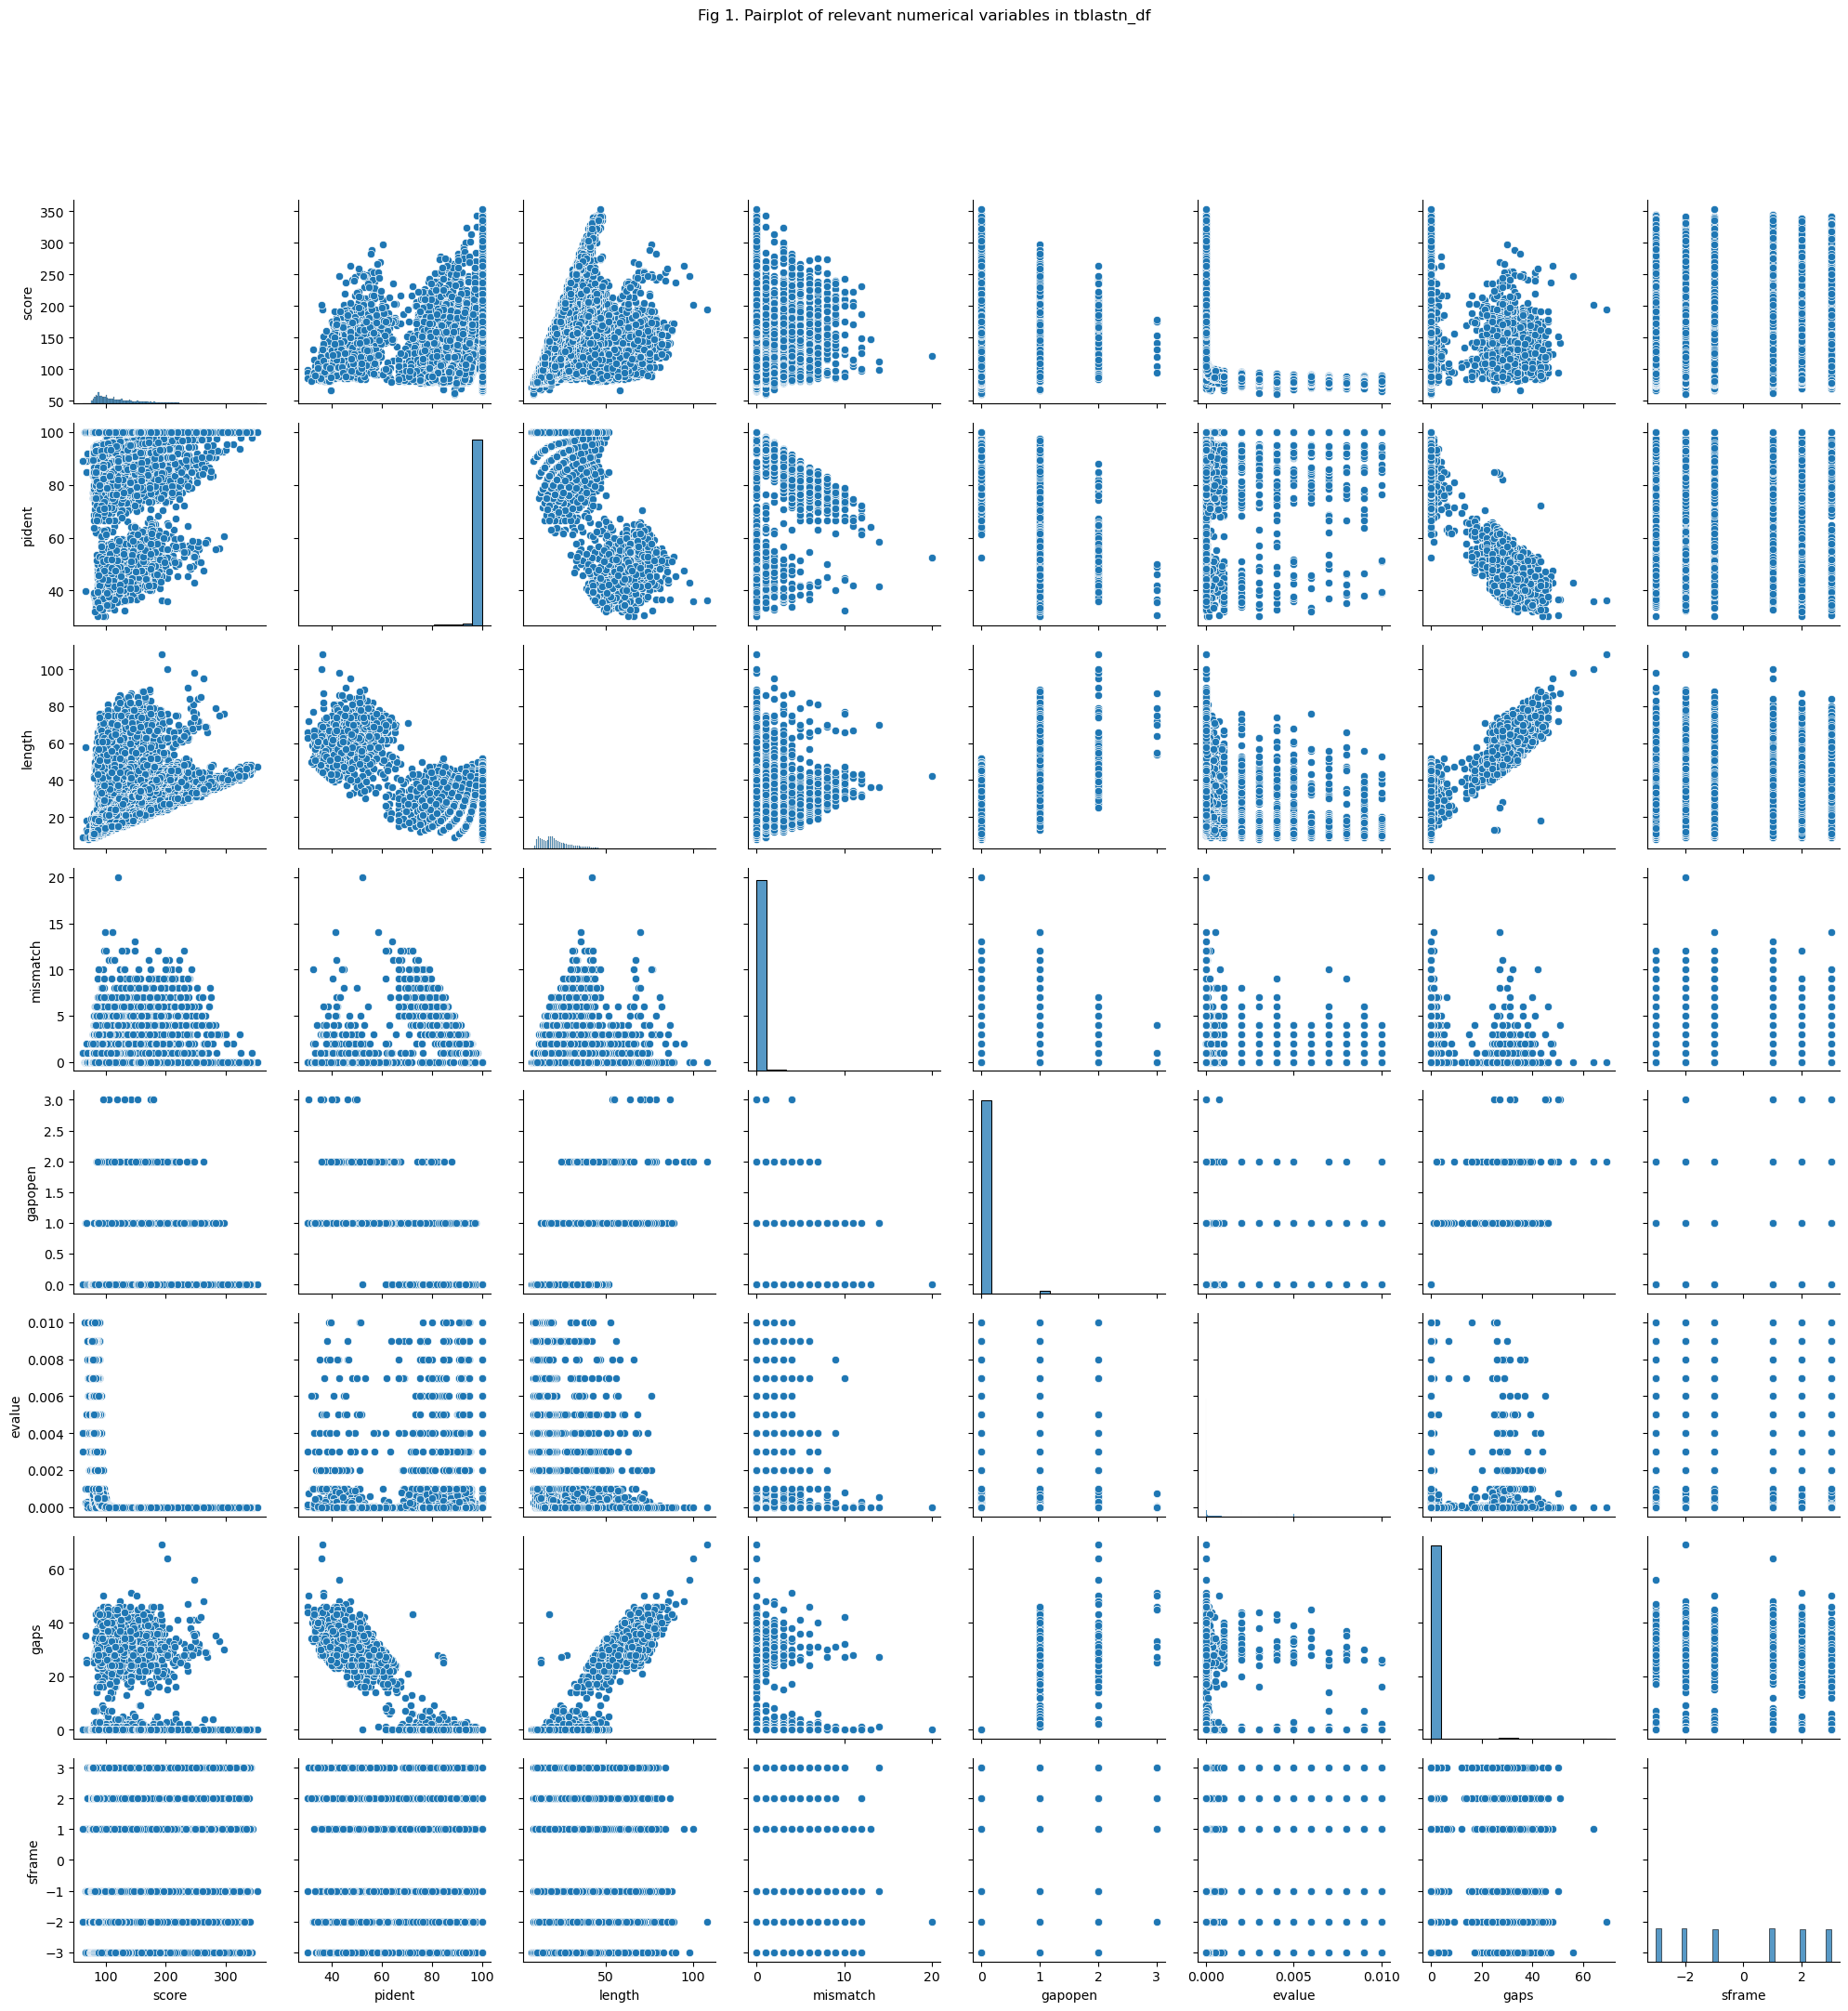

In [46]:
# NOTE: this takes a few minutes
# plotting all numerical variables
tblastn_df1 = tblastn_df[["score","pident","length","mismatch","gapopen","evalue","gaps","sframe"]]
fig1 = plt.figure(figsize=(1,1), layout='constrained')
fig1 = sns.pairplot(tblastn_df1)
fig1.fig.suptitle("Fig 1. Pairplot of relevant numerical variables in tblastn_df", y=1.08) # y= some height>1
plt.tight_layout()
plt.savefig('tblastn_df_pairplot1.png', dpi=1500, bbox_inches='tight')
plt.show()

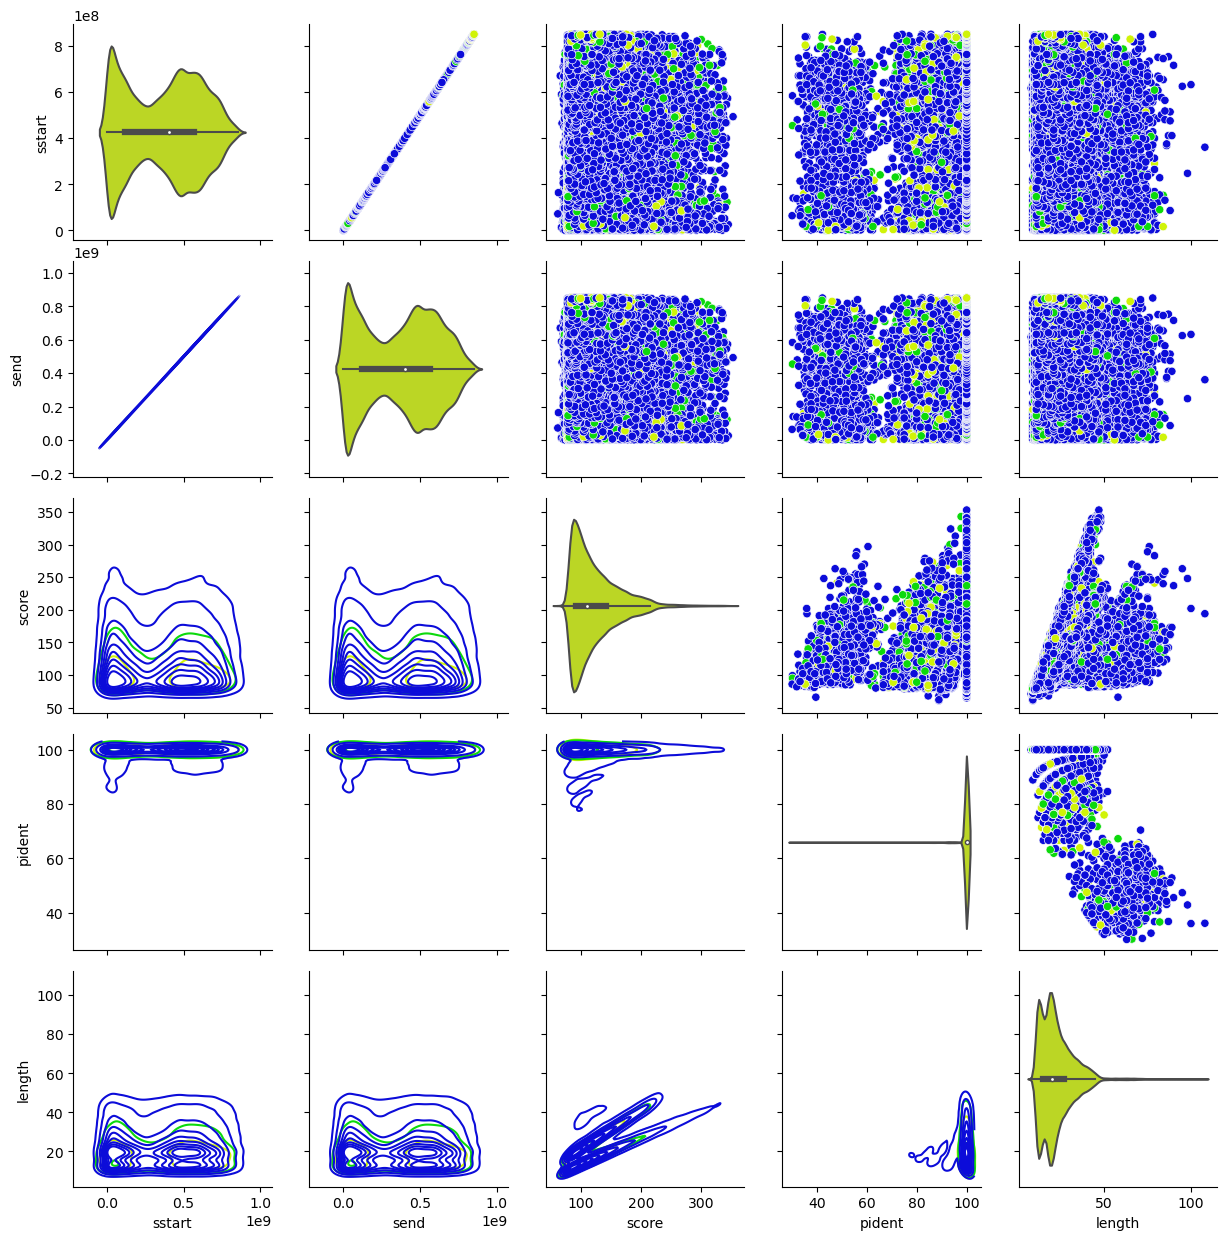

In [48]:
# NOTE: this takes even longer than the chart above
# multiple plots on numerical variables coloured by HLC-LC-novel
tblastn_df0 = tblastn_df[["sstart","send","score","pident","length","HCLC_nb"]]
fig1d = sns.PairGrid(tblastn_df0, hue='HCLC_nb', palette = ['#d0f308','#0cd90c','#0c0cd9'])
fig1d.map_upper(sns.scatterplot)
fig1d.map_lower(sns.kdeplot)
fig1d.map_diag(sns.violinplot)
plt.savefig('tblastn_df0_PairGrid.png', dpi=800, bbox_inches='tight')
plt.show()

   tissue_nb  chr_nb  score  strand_nb  pident  length  mismatch  gaps  gapopen        evalue  sframe  HCLC_nb
0          2       1     79          0   100.0      17         0     0        0  8.000000e-03      -1        3
1          2       1     82          0   100.0      18         0     0        0  3.000000e-03      -2        3
2          2       1    119          0   100.0      23         0     0        0  7.760000e-09      -2        3
3          2       1    119          0   100.0      23         0     0        0  4.980000e-08      -2        3
4          2       1     86          0   100.0      27         0     0        0  3.000000e-03      -2        3


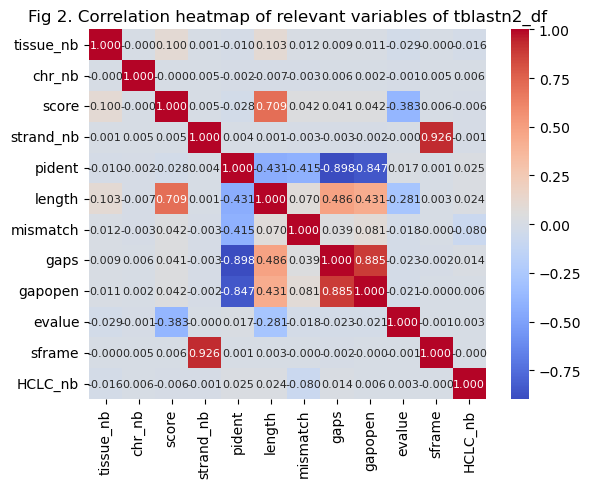

In [50]:
# isolating numerical variables
tblastn_df3 = tblastn_df[["tissue_nb","chr_nb","score","strand_nb","pident","length","mismatch","gaps","gapopen","evalue","sframe","HCLC_nb"]]
print(tblastn_df3.head())
# correlation matrix
corr_matrix = tblastn_df3.corr()
fig2 = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', annot_kws={"size": 8}, fmt='.3f')
fig2.set_title('Fig 2. Correlation heatmap of relevant variables of tblastn2_df')
plt.savefig('tblastn_df3_correlation-matrix.png', dpi=300, bbox_inches='tight')
plt.show()

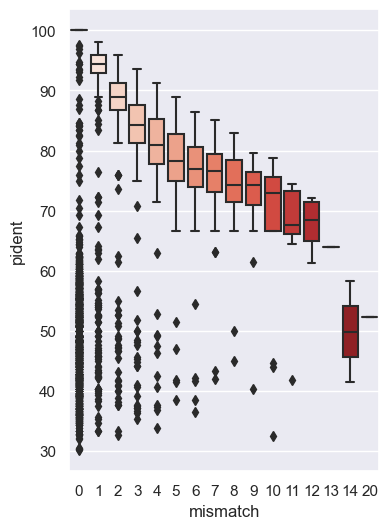

In [52]:
# boxplot of mismatch and pident
sns.set(font_scale = 1)
sns.set_theme(rc={'figure.figsize':(4,6)})
fig4 = sns.boxplot(x='mismatch', y='pident', data=tblastn_df, palette="Reds")
plt.savefig('tblastn_df_boxplot_mismatch-pident.png', dpi=400, bbox_inches='tight')
plt.show()

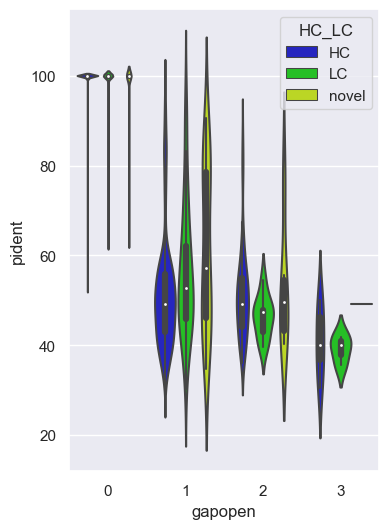

In [54]:
# violin plot coloured by HLC-LC-novel
plt.xlim(-1, 4)
sns.set(font_scale = 1)
sns.set_theme(rc={'figure.figsize':(7,6)})
fig5 = sns.violinplot(x = 'gapopen', y = 'pident', data=tblastn_df, orient='v', hue='HC_LC', palette = ['#0c0cd9','#0cd90c','#d0f308'])
#fig5.set_title('Fig 5. Violin plot of insurance costs based on number of children and coloured by smoking status')
plt.savefig('tblastn_df_violinplot_gapopen-pident.png', dpi=400, bbox_inches='tight')
plt.show()

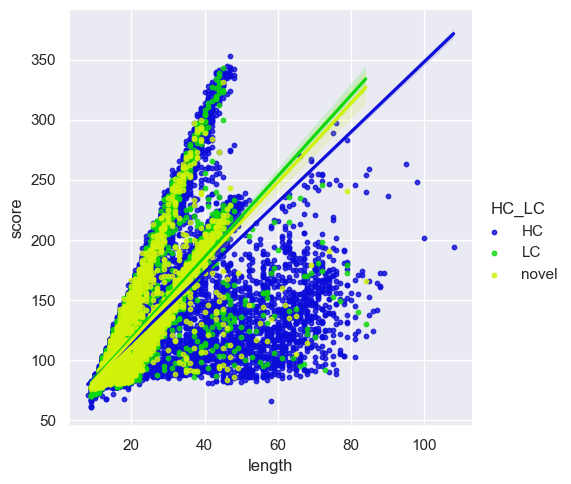

In [56]:
# scatterplot coloured by HLC-LC-novel
fig6 = sns.lmplot(x='length', y='score',data=tblastn_df, hue = 'HC_LC', palette = ['#0c0cd9','#0cd90c','#d0f308'], scatter_kws={"s": 10})
ax = plt.gca()
sns.set(font_scale = 1)
sns.set_theme(rc={'figure.figsize':(6,6)})
plt.savefig('tblastn_df_lmplot_score-length.png', dpi=400, bbox_inches='tight')
plt.show()

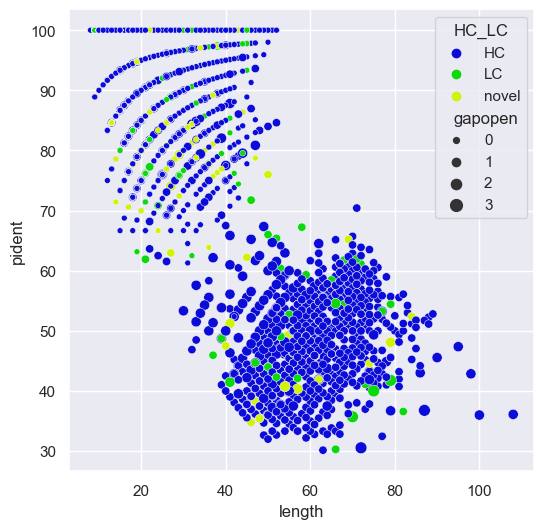

In [60]:
# scatterplot coloured by HLC-LC-novel
fig7 = sns.scatterplot(x='length', y='pident',data=tblastn_df, size='gapopen', hue = 'HC_LC', palette = ['#0c0cd9','#0cd90c','#d0f308'])
ax = plt.gca()
sns.set(font_scale = 1)
sns.set_theme(rc={'figure.figsize':(6,6)})
plt.savefig('tblastn_df_scatterplot_pident-length.png', dpi=400, bbox_inches='tight')
plt.show()

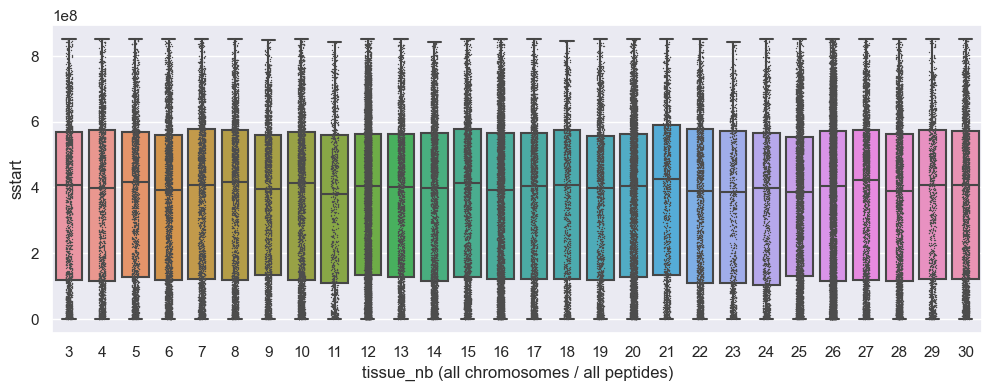

In [62]:
# box plot
#create a filtered dataframe
tblastn_df_tissue3_30 = tblastn_df[tblastn_df.tissue_nb > 2]
#print(tblastn_df_tissue3_30.tissue_nb.describe())
sns.set(font_scale = 1)
sns.set_theme(rc={'figure.figsize':(12,4)})
fig8 = sns.boxplot(x='tissue_nb', y='sstart', data=tblastn_df_tissue3_30)
fig8.set(xlabel="tissue_nb (all chromosomes / all peptides)")
sns.color_palette("Spectral", as_cmap=True)
sns.stripplot(tblastn_df_tissue3_30, x="tissue_nb", y="sstart", size=1, color=".3")
plt.savefig('tblastn_df_tissue3_30_boxplot_tissue_nb-sstart.png', dpi=400, bbox_inches='tight')
plt.show()


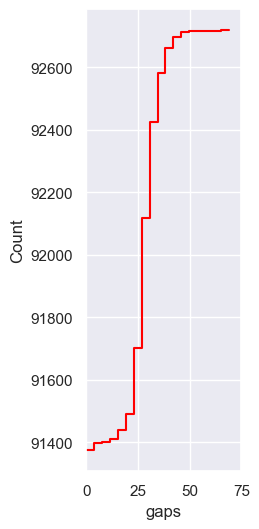

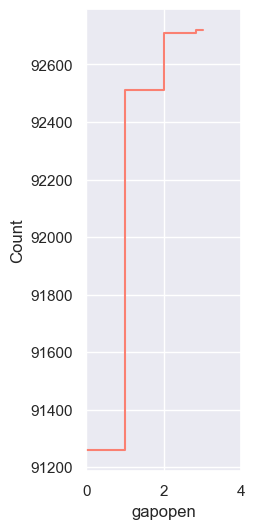

In [64]:
# histogram
sns.set(font_scale = 1)
sns.set_theme(rc={'figure.figsize':(2,6)})
plt.xlim(0,75)
fig9 = sns.histplot(data=tblastn_df, x='gaps', cumulative=True, element='step', fill=False, color='red')
#plt.ylim(50,250)
plt.savefig('tblastn_df_histplot_gaps.png', dpi=400, bbox_inches='tight')
plt.show()
plt.clf()
sns.set(font_scale = 1)
sns.set_theme(rc={'figure.figsize':(2,6)})
plt.xlim(0,4)
fig10 = sns.histplot(data=tblastn_df, x='gapopen', cumulative=True, element='step', fill=False, color='salmon')
plt.savefig('tblastn_df_histplot_gapopen.png', dpi=400, bbox_inches='tight')
plt.show() 

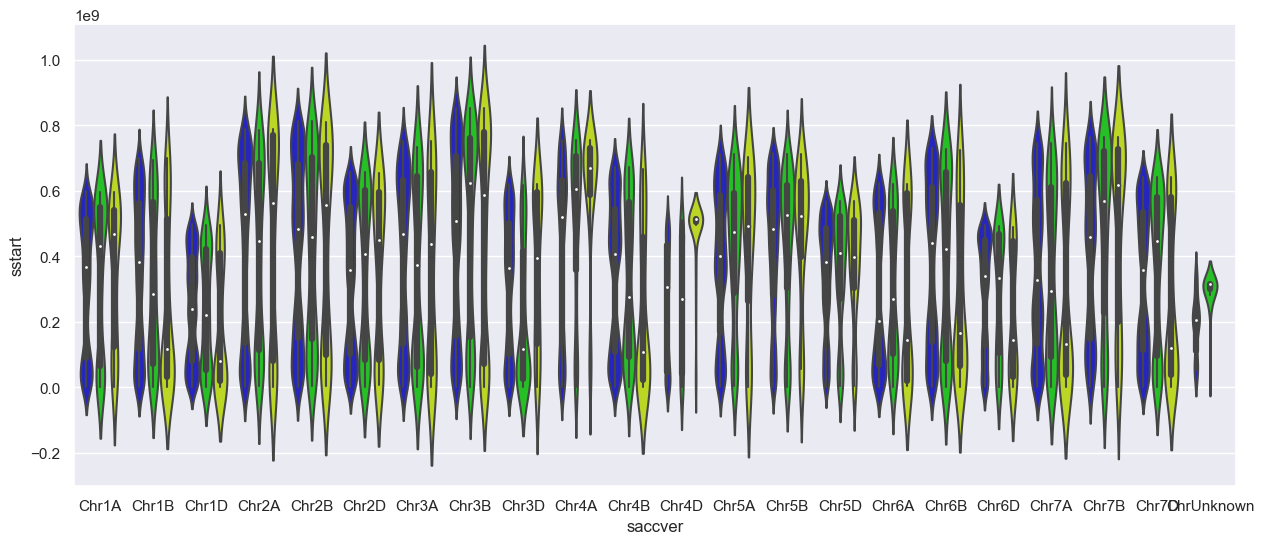

In [68]:
# violin plot
sns.set(font_scale = 1)
sns.set_theme(rc={'figure.figsize':(15,6)})
fig11 = sns.violinplot(x = 'saccver', y = 'sstart', data=tblastn_df, orient='v', hue = 'HC_LC', palette = ['#0c0cd9','#0cd90c','#d0f308'], legend=False)
#fig5.set_title('Fig 5. Violin plot of insurance costs based on number of children and coloured by smoking status')
#sns.color_palette("flare", as_cmap=True)
#plt.xlim(-1, 4)
fig11.legend_.remove()
plt.savefig('tblastn_df_violinplot_chr-sstart.png', dpi=600, bbox_inches='tight')
plt.show()

## Novel peptides

In [70]:
# filtering novel genes in all chromosomes
tblastn_df_novel = tblastn_df[tblastn_df.HC_LC == 'novel']
print('tblastn_df_novel dataframe:')
print("Dimensions of tblastn_df_novel DataFrame: ", tblastn_df_novel.shape) # (2934, 30)
print("Columns of tblastn_df_novel DataFrame: ", tblastn_df_novel.columns)
print(tblastn_df_novel.head())
print(tblastn_df_novel.describe())

tblastn_df_novel dataframe:
Dimensions of tblastn_df_novel DataFrame:  (2934, 30)
Columns of tblastn_df_novel DataFrame:  Index(['index', 'Source', 'tissue', 'tissue_nb', 'protein', 'qseq', 'chr_nb',
       'saccver', 'sstart', 'send', 'qseq.1', 'score', 'strand', 'strand_nb',
       'qaccver', 'pident', 'length', 'mismatch', 'gapopen', 'evalue',
       'bitscore', 'nident', 'positive', 'gaps', 'ppos', 'qframe', 'sframe',
       'gene', 'HC_LC', 'HCLC_nb'],
      dtype='object')
      index             Source                    tissue  tissue_nb                                            protein                                         qseq  chr_nb saccver     sstart       send                                       qseq.1  score strand  strand_nb                                            qaccver   pident  length  mismatch  gapopen        evalue  bitscore  nident  positive  gaps    ppos  qframe  sframe  gene  HC_LC  HCLC_nb
5330   1876  Duncan et al 2017  02_GRAIN_DEVELOPMENT_Z87       

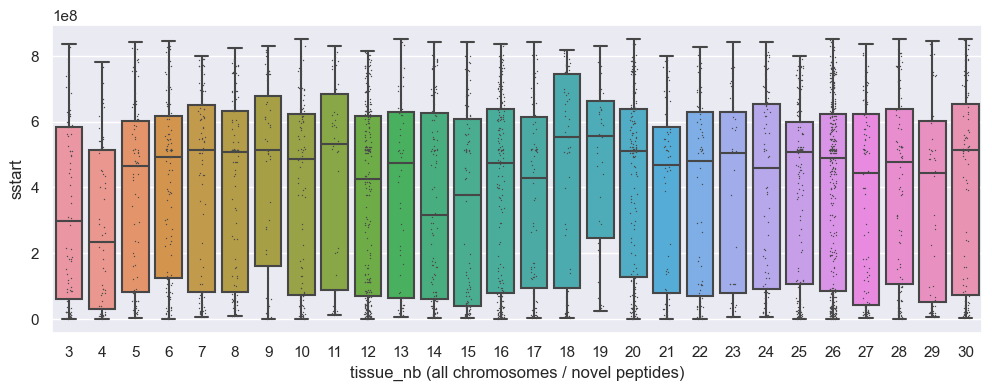

In [72]:
# box plot
sns.set(font_scale = 1)
sns.set_theme(rc={'figure.figsize':(12,4)})
fig12 = sns.boxplot(x='tissue_nb', y='sstart', data=tblastn_df_novel)
fig12.set(xlabel="tissue_nb (all chromosomes / novel peptides)")
sns.color_palette("Spectral", as_cmap=True)
sns.stripplot(tblastn_df_novel, x="tissue_nb", y="sstart", size=1, color=".3")
plt.savefig('tblastn_df_novel_boxplot_tissue_nb-sstart.png', dpi=400, bbox_inches='tight')
plt.show()


## Chromosome 4D
based on the figure above, 4D has less peptides and most of them are novel. Novel peptides align with end region of chromosome 4D. Ask Rudi about this chromosome.

In [78]:
# it seems chro 4D is unusual, let's explore this
# filtering 4d in
tblastn_df_4D = tblastn_df[tblastn_df.saccver == 'Chr4D']
print('tblastn_df_4D dataframe:')
print("Dimensions of tblastn_df_4D DataFrame: ", tblastn_df_4D.shape) # (4399, 33)
print(tblastn_df_4D.head())


tblastn_df_4D dataframe:
Dimensions of tblastn_df_4D DataFrame:  (4399, 30)
      index                   Source           tissue  tissue_nb                  protein                      qseq  chr_nb saccver   sstart     send                    qseq.1  score strand  strand_nb                             qaccver  pident  length  mismatch  gapopen        evalue  bitscore  nident  positive  gaps   ppos  qframe  sframe                   gene HC_LC  HCLC_nb
2835  51365  Vincent et al 2022 2023  01_STORED_GRAIN          2  TraesCS4D03G0003900LC.1  KRPQEEQDGAEPNKPEGPETPTQK      12   Chr4D  1298968  1299039  KRPQEEQDGAEPNKPEGPETPTQK    110      +          1  TraesCS4D03G0003900LC.1_pep_066200   100.0      24         0        0  3.700000e-07      55.4      24        24     0  100.0       0       1  TraesCS4D03G0003900LC    LC        2
2836  51366  Vincent et al 2022 2023  01_STORED_GRAIN          2  TraesCS4D03G0003900LC.1  KRPQEEQDGAEPNKPEGPETPTQK      12   Chr4D  1298968  1299039  KRPQEEQDGAE

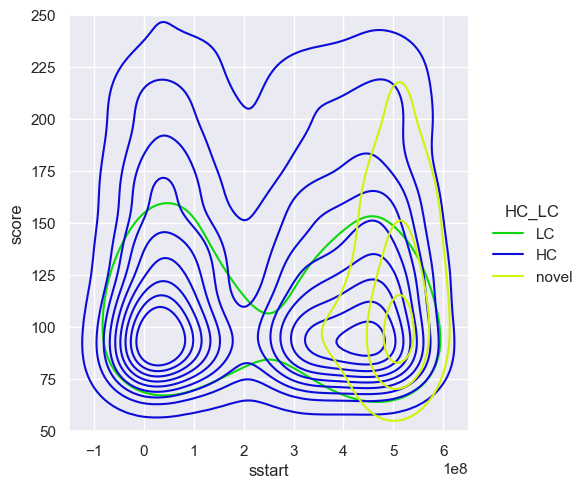

In [82]:
# scatterplot of 4D
fig12 = sns.displot(x='sstart', y='score', data=tblastn_df_4D, kind='kde', hue = 'HC_LC', palette = ['#0cd90c','#0c0cd9','#d0f308'])
#fig12.set_title('Fig 3. Scatterplot of score vs. length coloured by HC_LC_novel')
#sns.move_legend(fig3, "upper right")
sns.set(font_scale = 1)
plt.xlim(-150000000, 650000000)
plt.ylim(50,250)
sns.set_theme(rc={'figure.figsize':(10,6)})
plt.savefig('tblastn_df_displot_sstart-score.png', dpi=400, bbox_inches='tight')
plt.show()

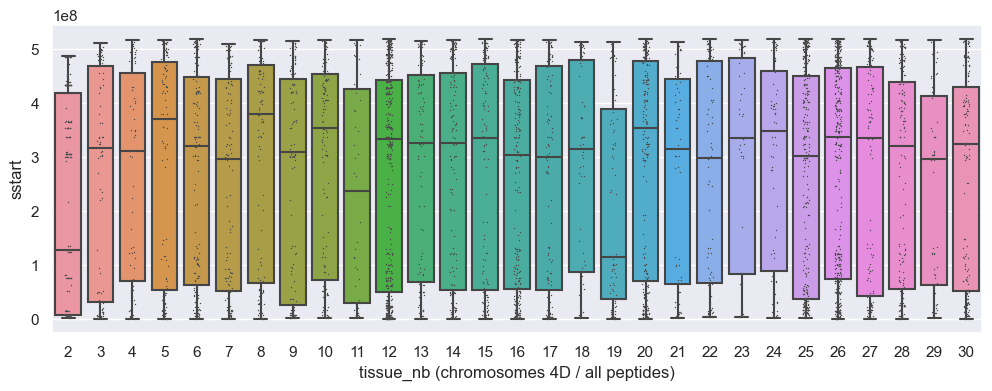

In [84]:
# box plot
sns.set(font_scale = 1)
sns.set_theme(rc={'figure.figsize':(12,4)})
fig13 = sns.boxplot(x='tissue_nb', y='sstart', data=tblastn_df_4D)
fig13.set(xlabel="tissue_nb (chromosomes 4D / all peptides)")
sns.color_palette("Spectral", as_cmap=True)
sns.stripplot(tblastn_df_4D, x="tissue_nb", y="sstart", size=1, color=".3")
#fig5.set_title('Fig 5. Violin plot of insurance costs based on number of children and coloured by smoking status')
#plt.xlim(1, 31)
plt.savefig('tblastn_df_4D_boxplot_tissue_nb-sstart.png', dpi=400, bbox_inches='tight')
plt.show()

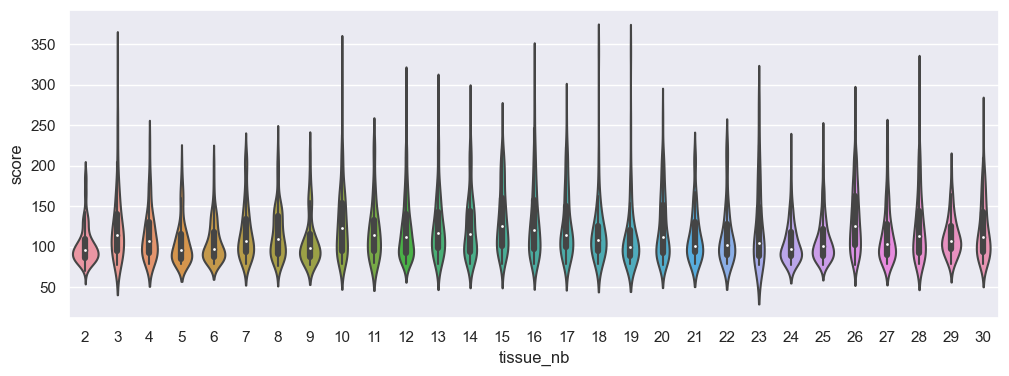

In [86]:
# violin plot
sns.set(font_scale = 1)
sns.set_theme(rc={'figure.figsize':(12,4)})
fig14 = sns.violinplot(x='tissue_nb', y='score', data=tblastn_df_4D)
sns.color_palette("Spectral", as_cmap=True)
#fig5.set_title('Fig 5. Violin plot of insurance costs based on number of children and coloured by smoking status')
#plt.xlim(1, 31)
#plt.savefig('tblastn_df_4D_violinplot_tissue_nb-score.png', dpi=300, bbox_inches='tight')
plt.show()

In [88]:
# filtering novel genes in 4D
tblastn_df_4D_novel = tblastn_df_4D[tblastn_df_4D.HC_LC == 'novel']
print('tblastn2_df_4D_novel dataframe:')
print("Dimensions of tblastn2_df_4D_novel DataFrame: ", tblastn_df_4D_novel.shape) # (274, 33)
print("Columns of tblastn2_df_4D_novel DataFrame: ", tblastn_df_4D_novel.columns)
print(tblastn_df_4D_novel.head())

tblastn2_df_4D_novel dataframe:
Dimensions of tblastn2_df_4D_novel DataFrame:  (274, 30)
Columns of tblastn2_df_4D_novel DataFrame:  Index(['index', 'Source', 'tissue', 'tissue_nb', 'protein', 'qseq', 'chr_nb',
       'saccver', 'sstart', 'send', 'qseq.1', 'score', 'strand', 'strand_nb',
       'qaccver', 'pident', 'length', 'mismatch', 'gapopen', 'evalue',
       'bitscore', 'nident', 'positive', 'gaps', 'ppos', 'qframe', 'sframe',
       'gene', 'HC_LC', 'HCLC_nb'],
      dtype='object')
      index             Source                    tissue  tissue_nb                                     protein                           qseq  chr_nb saccver     sstart       send                         qseq.1  score strand  strand_nb                                     qaccver  pident  length  mismatch  gapopen        evalue  bitscore  nident  positive  gaps   ppos  qframe  sframe  gene  HC_LC  HCLC_nb
6359  51754  Duncan et al 2017  02_GRAIN_DEVELOPMENT_Z87          3  Traes_4DS_7F1D0684B.1||AT5G

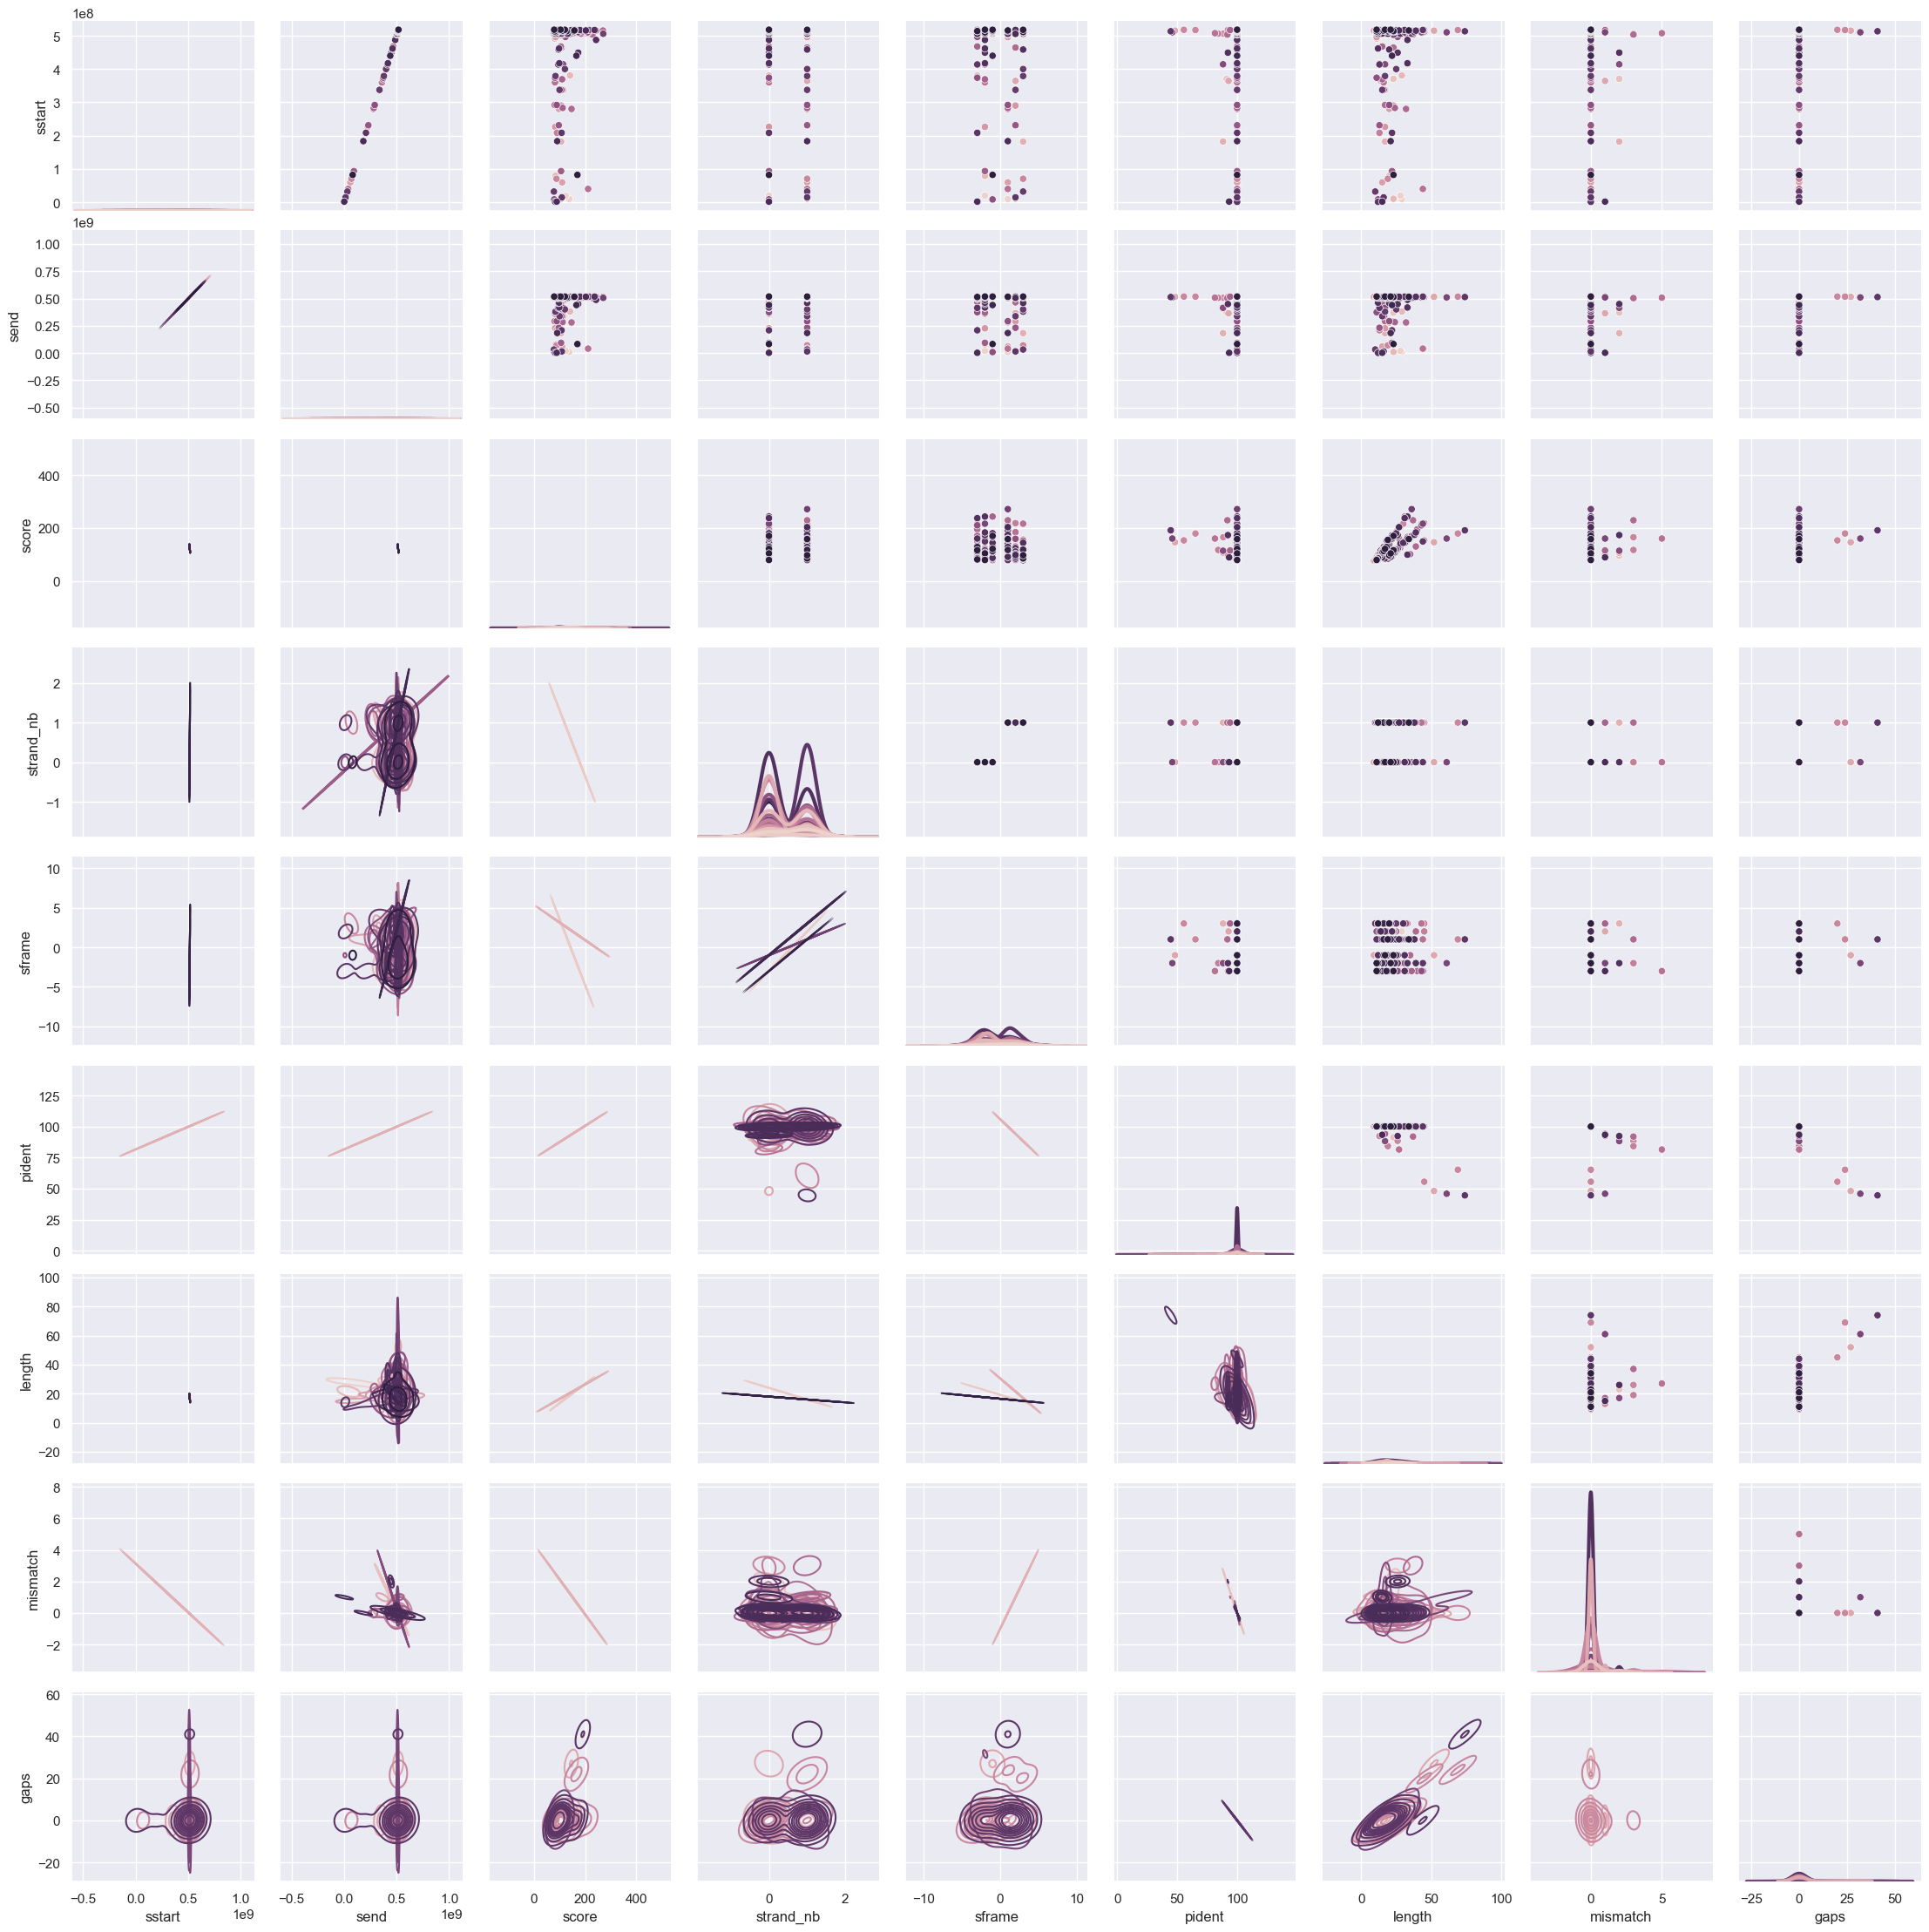

In [90]:
# NOTE: this takes a few minutes
# multiple plots on all numerical variables
tblastn_df1_4D_novel = tblastn_df_4D_novel[["tissue_nb","sstart","send","score",'strand_nb','sframe',"pident","length",'mismatch','gaps']]
sns.color_palette("Spectral", as_cmap=True)
fig15 = sns.PairGrid(tblastn_df1_4D_novel, hue='tissue_nb')
fig15.map_upper(sns.scatterplot)
fig15.map_lower(sns.kdeplot)
fig15.map_diag(sns.kdeplot, lw=3, legend=False)
plt.savefig('tblastn_df1_4D_novel_PairGrid_all.png', dpi=1000, bbox_inches='tight')
plt.show()

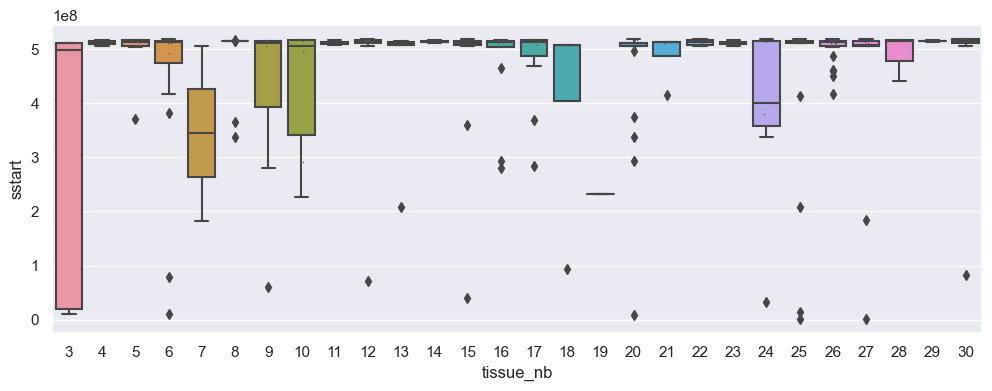

In [92]:
# violin plot
tblastn_df2_4D_novel = tblastn_df_4D_novel[["tissue_nb","sstart","send","score","pident","length",'mismatch','gaps']]
sns.set_theme(style="white", palette="deep")
sns.set(font_scale = 1)
sns.set_theme(rc={'figure.figsize':(12,4)})
fig16 = sns.boxplot(x='tissue_nb', y='sstart', data=tblastn_df2_4D_novel)
sns.color_palette("Spectral", as_cmap=True)
sns.stripplot(tblastn_df2_4D_novel, x="tissue_nb", y="sstart", size=1, color=".3")
#fig5.set_title('Fig 5. Violin plot of insurance costs based on number of children and coloured by smoking status')
#plt.xlim(1, 31)
plt.savefig('tblastn_df_4D_novel_boxplot_tissue_nb-score.png', dpi=400, bbox_inches='tight')
plt.show()

## ProtParam
The code below takes as input a fasta file of the peptides you want to compute ProtParams on. 
files needed:   
- 3: TraesCS4D03G0026600_peptides_list_manual_tBLASTn.fasta   

For more information on SeqUtils, see links:     
https://biopython.org/docs/1.76/api/Bio.SeqUtils.ProtParam.html   
https://github.com/biopython/biopython/blob/master/Bio/SeqUtils/ProtParam.py

In [4]:
# MW
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
input_file = open ("TraesCS4D03G0026600_peptides_list_manual_tBLASTn.fasta", "r")
for record in SeqIO.parse(input_file, "fasta"):
    my_seq = str(record.seq).rstrip('\\')
    analyse = ProteinAnalysis(my_seq)
    print(analyse.molecular_weight())

1368.5249999999999
1212.3392999999999
632.6687000000001
1413.3639
991.1463999999999
1960.1533
1189.3209
1415.6361
1571.8218
2046.4428000000003
1028.2262999999998
2336.5565999999994
2465.6705999999995
3139.422700000001
3261.592200000001
2421.5687000000007
2019.2121000000002
1045.1477
2122.3617
2278.5474
1822.0938
1092.2918
1013.1504
1699.9856
1552.8117999999997
1261.5094
1114.3355999999999
828.0081
1259.4092
904.9217000000001
831.871
2316.4497
1360.5146000000002
997.1495000000002
1280.3917
2310.6239
641.8427
1371.5323
2119.4406
1297.3908999999999
1225.3745999999999
1563.5417
1350.3047
1164.0948
1918.7970999999998
2567.5049
2317.648
3642.0143
1990.1743000000001
1415.5103
2237.517
700.8287
1657.8250000000003
1429.5799999999997
905.994
1235.3032
2571.5380999999998
2743.6767999999997
2456.4506999999994
2784.7750999999994
1955.9909000000002
2128.1296
1960.1533
1415.6361
1571.8218
2336.5565999999994
3139.422700000001
3261.592200000001
2421.5687000000007
2019.2121000000002
2122.3617
2278.5474


In [6]:
# GRAVY
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
input_file = open ("TraesCS4D03G0026600_peptides_list_manual_tBLASTn.fasta", "r")
for record in SeqIO.parse(input_file, "fasta"):
    my_seq = str(record.seq).rstrip('\\')
    analyse = ProteinAnalysis(my_seq)
    print(analyse.gravy())

-1.1500000000000001
-0.8454545454545456
-1.6
-2.8666666666666667
-0.8624999999999999
-0.6235294117647059
-0.5800000000000001
0.1499999999999999
-0.2076923076923078
0.0705882352941176
0.38888888888888906
0.29130434782608694
0.1333333333333333
0.303225806451613
0.18437500000000012
-0.18333333333333338
0.07500000000000002
-1.2555555555555555
0.11904761904761914
-0.09090909090909083
0.55
0.5800000000000001
0.03333333333333331
0.26666666666666666
0.0857142857142857
0.49999999999999983
0.2909090909090909
0.7625
-0.8545454545454544
-1.6375
-1.457142857142857
-1.4238095238095239
-1.3
-1.6125
-0.390909090909091
0.17272727272727287
2.316666666666667
0.25384615384615394
0.625
-0.3500000000000001
-0.22727272727272735
-3.0500000000000003
-3.17
-3.4222222222222225
-2.5411764705882356
-2.227272727272727
0.1590909090909091
0.19142857142857142
0.09000000000000007
-1.5363636363636362
-0.41
0.6666666666666666
-0.7066666666666668
-0.8384615384615386
-0.5428571428571428
-1.7100000000000002
-2.1636363636363

In [8]:
# aromaticity
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
input_file = open ("TraesCS4D03G0026600_peptides_list_manual_tBLASTn.fasta", "r")
for record in SeqIO.parse(input_file, "fasta"):
    my_seq = str(record.seq).rstrip('\\')
    analyse = ProteinAnalysis(my_seq)
    print(analyse.aromaticity())

0.0
0.0
0.2
0.0
0.25
0.11764705882352941
0.1
0.08333333333333333
0.07692307692307693
0.058823529411764705
0.0
0.13043478260869565
0.125
0.0967741935483871
0.0625
0.041666666666666664
0.05
0.0
0.0
0.0
0.0
0.0
0.1111111111111111
0.2
0.14285714285714285
0.08333333333333333
0.0
0.0
0.0
0.0
0.0
0.09523809523809523
0.09090909090909091
0.0
0.09090909090909091
0.09090909090909091
0.0
0.0
0.0
0.0
0.0
0.08333333333333333
0.1
0.0
0.0
0.045454545454545456
0.045454545454545456
0.05714285714285714
0.0
0.09090909090909091
0.05
0.16666666666666666
0.06666666666666667
0.07692307692307693
0.14285714285714285
0.1
0.045454545454545456
0.041666666666666664
0.047619047619047616
0.041666666666666664
0.058823529411764705
0.05263157894736842
0.11764705882352941
0.08333333333333333
0.07692307692307693
0.13043478260869565
0.0967741935483871
0.0625
0.041666666666666664
0.05
0.0
0.0
0.0
0.14285714285714285
0.08333333333333333
0.09523809523809523
0.09090909090909091
0.09090909090909091
0.045454545454545456
0.057142

In [10]:
# isoelectric_point
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
input_file = open ("TraesCS4D03G0026600_peptides_list_manual_tBLASTn.fasta", "r")
for record in SeqIO.parse(input_file, "fasta"):
    my_seq = str(record.seq).rstrip('\\')
    analyse = ProteinAnalysis(my_seq)
    print(analyse.isoelectric_point())

10.352155876159667
8.258609580993653
8.75482273101807
4.471944236755371
10.835024070739745
6.475461769104004
6.115045738220213
6.115045738220213
9.555133247375487
11.539018821716308
5.972209358215332
4.207756614685059
4.320695686340333
4.0500284194946286
4.177631950378417
4.0500284194946286
4.25265941619873
5.8100477218627935
5.210851097106932
6.747947883605957
6.7146402359008786
9.756532478332517
9.756532478332517
9.703023719787598
9.703023719787598
10.002737236022949
10.000738716125486
9.179991722106934
6.0697450637817365
4.368156242370605
4.531568336486816
6.92352352142334
6.0697450637817365
8.74786014556885
6.65956325531006
8.56148204803467
8.750052070617677
4.329448890686037
4.481720542907715
4.0880537033081055
5.508119010925292
4.359289360046388
4.079129981994629
4.078788948059082
4.138413047790528
4.300688362121583
11.698964881896973
4.7519330978393555
5.238929557800293
4.786434364318848
8.745926094055175
9.72004337310791
6.070427131652831
9.314859580993652
4.531682014465332
4.8

In [14]:
# molar_extinction_coefficient
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
input_file = open ("TraesCS4D03G0026600_peptides_list_manual_tBLASTn.fasta", "r")
for record in SeqIO.parse(input_file, "fasta"):
    my_seq = str(record.seq).rstrip('\\')
    analyse = ProteinAnalysis(my_seq)
    print(analyse.molar_extinction_coefficient())

(0, 0)
(0, 0)
(1490, 1490)
(0, 0)
(1490, 1490)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(1490, 1490)
(0, 0)
(1490, 1490)
(1490, 1490)
(1490, 1490)
(1490, 1490)
(1490, 1490)
(1490, 1490)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(1490, 1490)
(1490, 1490)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(5500, 5500)
(0, 0)
(0, 0)
(0, 0)
(1490, 1490)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(5500, 5500)
(5500, 5500)
(0, 0)
(0, 0)
(1490, 1490)
(0, 0)
(0, 0)
(0, 0)
(5500, 5500)
(5500, 5500)
(5500, 5500)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(1490, 1490)
(1490, 1490)
(1490, 1490)
(1490, 1490)
(1490, 1490)
(0, 0)
(0, 0)
(0, 0)
(1490, 1490)
(0, 0)
(5500, 5500)
(0, 0)
(1490, 1490)
(0, 0)
(0, 0)
(0, 0)
(5500, 5500)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)


In [ ]:
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
input_file = open ("TraesCS4D03G0026600_peptides_list_manual_tBLASTn.fasta", "r")
for record in SeqIO.parse(input_file, "fasta"):
    my_seq = str(record.seq).rstrip('\\')
    analyse = ProteinAnalysis(my_seq)
    print(analyse.gravy())

In [ ]:
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
input_file = open ("TraesCS4D03G0026600_peptides_list_manual_tBLASTn.fasta", "r")
for record in SeqIO.parse(input_file, "fasta"):
    my_seq = str(record.seq).rstrip('\\')
    analyse = ProteinAnalysis(my_seq)
    print(analyse.gravy())

## Peptides and genes per chromosome
Below I plot some aggregated numbers per chromosome.

file needed:   
- 4:peptides-genes-chromosomes.txt

In [100]:
# Load Peptides with gene names
pep_chr_file = "peptides-genes-chromosomes.txt" # NOTE: txt file was created from excel
pep_chr_df = pd.read_csv(pep_chr_file, sep="\t")
print('pep_chr_df dataframe:')
print("Dimensions of pep_chr_df DataFrame: ", pep_chr_df.shape) # (92719, 33)
print("Columns of pep_chr_df DataFrame: ", pep_chr_df.columns)
print(pep_chr_df)

pep_chr_df dataframe:
Dimensions of pep_chr_df DataFrame:  (21, 17)
Columns of pep_chr_df DataFrame:  Index(['chro_nb', 'genome', 'Chromosome', 'HC_peptides', 'LC_peptides',
       'novel_peptides', 'SUM_peptides', 'HC_pep-mapped_genes',
       'LC_pep-mapped_genes', 'SUM_pep-mapped_genes', 'HC_genes', 'LC_genes',
       'SUM_genes', 'HC_%', 'LC_%', 'SUM_%', 'Chro_size'],
      dtype='object')
    chro_nb genome Chromosome  HC_peptides  LC_peptides  novel_peptides  SUM_peptides  HC_pep-mapped_genes  LC_pep-mapped_genes  SUM_pep-mapped_genes  HC_genes  LC_genes  SUM_genes  HC_%  LC_%  SUM_%  Chro_size
0         1      A      Chr1A         2883          235              79          3197                 1286                  128                  1414      4359      6509      10868  29.5   2.0   13.0  594442527
1         1      B      Chr1B         3957          296             154          4407                 1515                  173                  1688      4736      8112      12848 

In [102]:
print(pep_chr_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   chro_nb               21 non-null     int64  
 1   genome                21 non-null     object 
 2   Chromosome            21 non-null     object 
 3   HC_peptides           21 non-null     int64  
 4   LC_peptides           21 non-null     int64  
 5   novel_peptides        21 non-null     int64  
 6   SUM_peptides          21 non-null     int64  
 7   HC_pep-mapped_genes   21 non-null     int64  
 8   LC_pep-mapped_genes   21 non-null     int64  
 9   SUM_pep-mapped_genes  21 non-null     int64  
 10  HC_genes              21 non-null     int64  
 11  LC_genes              21 non-null     int64  
 12  SUM_genes             21 non-null     int64  
 13  HC_%                  21 non-null     float64
 14  LC_%                  21 non-null     float64
 15  SUM_%                 21 

In [104]:
print(pep_chr_df.describe())

        chro_nb  HC_peptides  LC_peptides  novel_peptides  SUM_peptides  HC_pep-mapped_genes  LC_pep-mapped_genes  SUM_pep-mapped_genes     HC_genes     LC_genes     SUM_genes       HC_%       LC_%      SUM_%     Chro_size
count  21.00000    21.000000    21.000000       21.000000     21.000000            21.000000            21.000000             21.000000    21.000000    21.000000     21.000000  21.000000  21.000000  21.000000  2.100000e+01
mean    4.00000  3953.095238   318.333333      139.714286   4411.142857          1600.000000           176.000000           1776.000000  5025.476190  7410.952381  12436.428571  31.876190   2.347619  14.333333  6.772196e+08
std     2.04939  1166.215242   141.661686       92.065815   1354.573855           410.598953            75.549322            476.502676   744.916077  1233.029662   1862.892363   6.259226   0.713876   3.016179  1.019019e+08
min     1.00000  1991.000000   196.000000       63.000000   2304.000000           956.000000           103.0

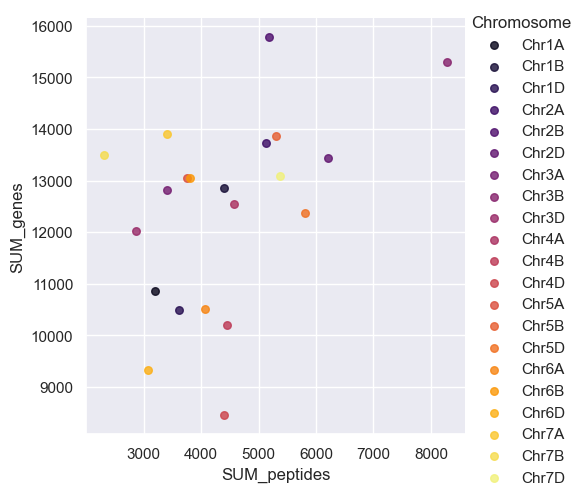

In [106]:
# scatterplot with trend line
fig1 = sns.lmplot(x='SUM_peptides', y='SUM_genes',data=pep_chr_df, hue = 'Chromosome', palette = 'inferno', scatter_kws={"s": 30})
ax = plt.gca()
sns.set(font_scale = 1)
sns.set_theme(rc={'figure.figsize':(6,6)})
#plt.savefig('pep_chr_df_lmplot_SUMpep-SUMgen.png', dpi=400, bbox_inches='tight')
plt.show()

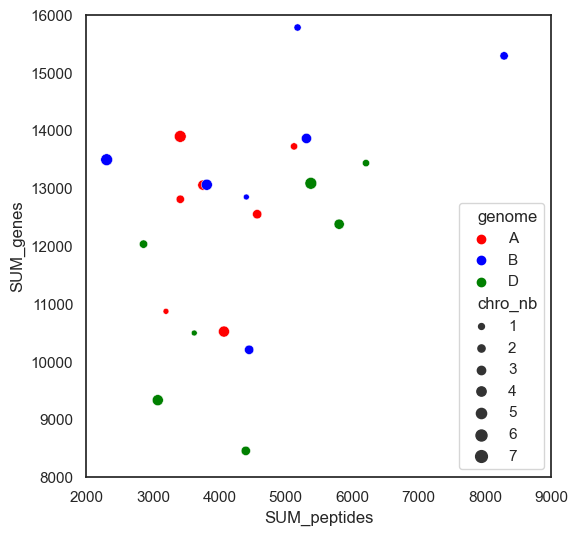

In [108]:
# scatterplot
sns.set_theme(style="white", palette="deep")
fig2 = sns.scatterplot(x='SUM_peptides', y='SUM_genes',data=pep_chr_df, size='chro_nb', hue = 'genome', palette = ['red','blue','green'])
ax = plt.gca()
sns.set(font_scale = 1)
sns.set_theme(rc={'figure.figsize':(6,6)})
plt.xlim(2000, 9000)
plt.ylim(8000, 16000)
#plt.savefig('pep_chr_df_scatterplot_SUMpep-SUMgen.png', dpi=400, bbox_inches='tight')
plt.show()

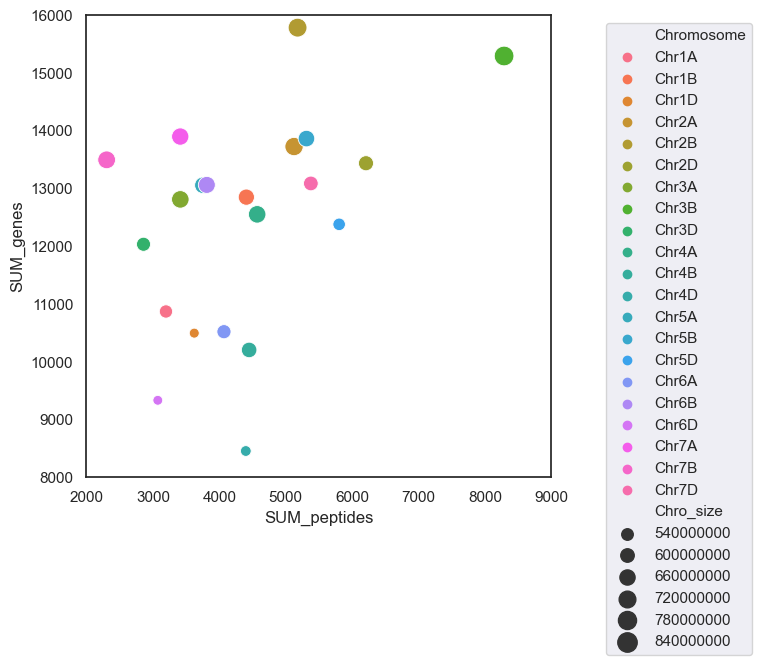

In [110]:
# scatterplot
sns.set_theme(style="white", palette="deep")
#fig2 = sns.scatterplot(x='SUM_peptides', y='SUM_genes',data=pep_chr_df, size='Chro_size', sizes=(50,200), hue = 'Chromosome', palette = 'deep')
fig2 = sns.scatterplot(x='SUM_peptides', y='SUM_genes',data=pep_chr_df, size='Chro_size', sizes=(50,200), hue = 'Chromosome')
h_neg= 1
h_pos= 358
sns.diverging_palette(h_neg, h_pos, s=75, l=50, sep=1, n=6, center='light', as_cmap=False)
ax = plt.gca()
sns.set(font_scale = 1)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.1, 1))
sns.set_theme(rc={'figure.figsize':(6,6)})
plt.xlim(2000, 9000)
plt.ylim(8000, 16000)
plt.savefig('pep_chr_df_scatterplot_SUMpep-SUMgen2.png', dpi=400, bbox_inches='tight')
plt.show()

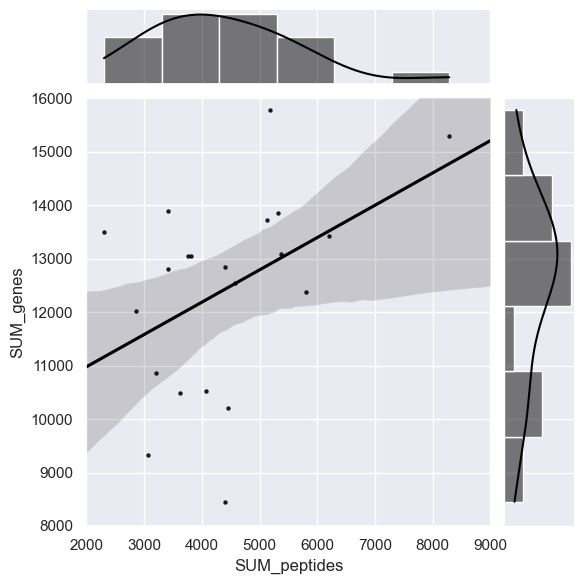

In [112]:
#sns.set_theme(style="darkgrid")
sns.set_theme(style="whitegrid", palette="deep")
sns.set_theme(rc={'figure.figsize':(6,6)})
fig3 = sns.jointplot(x='SUM_peptides', y='SUM_genes', data=pep_chr_df,
                  kind='reg', truncate=False,
                  xlim=(2000, 9000), ylim=(8000, 16000),
                  color="black", scatter_kws={"s": 5})
plt.savefig('pep_chr_df_joinplot_SUMpep-SUMgen.png', dpi=500, bbox_inches='tight')
plt.show()